### Part 3: Spike-Frequency Adaptation of DPI Neurons

As explained briefly in the Introduction of Part 1, silicon neurons on DynapSE are capable of spike-frequency adaptation. In neuroscience, spike-frequency adaptation is defined as reducing a neuron's firing rate to a stimulus of constant intensity. Hence, when stimulated with a constant stimulus, many neurons initially respond with a high spike frequency that decays down to a lower steady-state frequency. Do you remember when a smell seems to be fading after you get used to it? Yeah, this can be implemented with spike-frequency adaptation.

There are several mechanisms by which neurons can adapt to new stimulus statistics; for example, neurons can change their time constants or other neurons suppress its firing rate via feedback inhibition. Usually, these processes are slower than the dynamics of action potential generation.

In our silicon neurons, the spike-frequency adaptation mechanism is implemented by an additional DPI filter that models the neuron's Calcium conductance that produces the after-hyper-polarizing current $I_{ahp}$, which is proportional to the neuron's mean ﬁring rate. There are two biases on the chip to tune the strength of spike-frequency adaptation (don't forget, this is a DPI circuit). The rest will be taken care of by the physics of the silicon:

- $I_{tauahp}$ : Leakage current for spike-frequency adaptation (how fast the adaptation)
- $I_{thahp}$   : Threshold for spike-frequency adaptation (strength of the adaptation)


Let's start with importing Brian2.

In [1]:
from brian2 import *

import sys 
sys.path.append('..')
from DynapSE import DynapSE
from equations.dynapse_eq import *
from parameters.dynapse_param import *

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline 
mpl.rcParams['figure.dpi'] = 90  
set_device('cpp_standalone')

In Part 1 and Part 2, we created various spike trains, allocated neurons, and created synapses on the Dynap-SE1 simulator. In Part 3, we will learn another fundamental block of our neuromorphic chips, called Bias Generator (BiasGen). BiasGen is a configurable current generator that biases the gate voltage of specific transistors on the chip to generate the desired currents. By BiasGen, the user can adjust neuron and synapse parameters. In research, we spend a notable amount of time tuning network parameters via BiasGen so that the network operates in a specific regime that we choose.  You can check the original paper of BiasGen [here](https://ieeexplore.ieee.org/document/5537475). The current version of BiasGen inside the Dynap-SE1 is much more advanced. For example, it can compensate the temperature dependency of generated currents.


We will create a regular spiking pattern and tune two biases, `Itauahp` and `Ithahp,` for observing a spike-frequency adaptation. With correct values, you should see the firing rate adapting to the constant stimulus after some time. 

To control BiasGen, we will use the `set_bias(dict, 'core_ID')` method, which takes a dictionary of address, current pairs, and the Core ID. Core ID is required because the biases are shared within a single core of DynapSE.

In [2]:
## Observing Adaptation Effect
##################
# TODO:
# - Play with Itauahp and Ithahp currents to observe a spike-frequency adaptation
#
#
# Parameters
pulse_start  = 1     # second - Start timing of pulse
pulse_stop   = 4     # second - Stop timing of pulse
inp_duration = 5     # second - Simulation duration
firing_rate  = 150   # Hz - Firing rate of the source

adaptation_conf = {"Isoma_ahp_tau": 1 * pA}  # Adaptation time constant (Default: 0.04 pA, 0.05 pA)             
#                   "Isoma_ahp_g" : 4 * pA}  # Adaptation gain


ampa_conf       = {"Iampa_tau": 20 * pA} # AMPA synapse time-constant (Default: 10 pA, 10pA)
                   
##################

# Reinitialize the device
device.reinit()
device.activate()
defaultclock.dt = 20 * us
# Ignore Brian2 base warnings
BrianLogger.suppress_name('base')

# Create a regular spiking pattern (taken from Part 1.)
spikes = np.zeros(inp_duration*1000)
dt = int(1000/firing_rate)
spikes[pulse_start*1000:pulse_stop*1000:dt] = 1.0
spike_timing = np.where(spikes==1)[0] * ms
neuron_indices = np.zeros(len(spike_timing))
input_spike_generator = SpikeGeneratorGroup(1, indices=neuron_indices, times=spike_timing, name='InpSpikeGenerator')    

# Create a Brian2 network and chip instance using that monitors DynapSE resources.
network = Network()
chip = DynapSE(network)

# Connect a single spike generator to a single DPI neuron 
DPI_neuron  = chip.get_neurons(1, 'Core_1')
DPI_synapse = chip.add_connection(input_spike_generator, DPI_neuron, synapse_type='AMPA')
chip.connect(DPI_synapse, True)
DPI_synapse.weight = 2


# Using BiasGen, set adaptation configurations for Core #1
# In DynapSE, biases are set per Core.
# In CTXCTL, this command is : set_bias(chip_id, bias_id, fine_value, coarse_value, t_type)
chip.set_bias(adaptation_conf, 'Core_1')
chip.set_bias(ampa_conf, 'Core_1')


# Monitors
mon_neuron_input  = SpikeMonitor(input_spike_generator, name='mon_neuron_input')
mon_neuron_output = SpikeMonitor(DPI_neuron, name='mon_neuron_output')
mon_adapt_state  = StateMonitor(DPI_neuron,  'Isoma_ahp', record=True)
mon_mem_state  = StateMonitor(DPI_neuron,  'Isoma_mem', record=True)
network.add([input_spike_generator, DPI_neuron, DPI_synapse, mon_neuron_input, mon_neuron_output,mon_adapt_state,mon_mem_state])

# Simulation
network.run(inp_duration * 1000 * ms)

1 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
New bias values are loaded to Core_1.


Now, we are going to monitor input-output spikes, membrane current, and the adaptation current. If you set up spike-adaptation currents correctly, you will see that the neuron firing rate will decrease in the presence of a constant input rate. Nevertheless, we have to warn you, tuning spike-frequency is a bit tricky, and its effect is visible with only a small set of parameters.

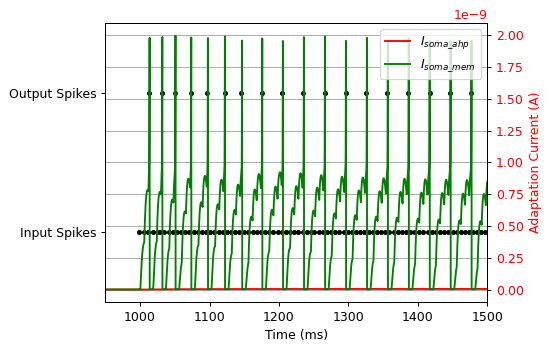

In [3]:
##################
#  TODO: 
# - Find the time window to observe spike-frequency adaptation.
#
# Parameters
tstart = 950 # ms - 
tend   = 1500 # ms -
##################

# Plotting
spike_placeholder = np.zeros(inp_duration*1000)
spike_placeholder[np.array(mon_neuron_input.t/ms, dtype=int)]=2

spike_placeholder2 = np.zeros(inp_duration*1000)
spike_placeholder2[np.array(mon_neuron_output.t/ms, dtype=int)]=3

s = int(1*ms / defaultclock.dt)
fig, ax1 = plt.subplots()

ax1.set_xlabel('Time (ms)')
ax1.plot(spike_placeholder,'k.')
plt.yticks(np.arange(1, 5), ['a','Input Spikes','Output Spikes','d'])
ax1.tick_params(axis='y')
plt.ylim(1.5, 3.5)
plt.xlim(tstart,tend)
ax2 = ax1.twinx()  
ax1.plot(spike_placeholder2,'k.')

ax2.set_ylabel('Adaptation Current (A)', color='r')  
ax2.plot(mon_adapt_state.t/ms, mon_adapt_state.Isoma_ahp[0], linewidth=1.5,color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.xlim(tstart,tend)


fig.tight_layout()
plt.grid(True)

ax2.plot(mon_mem_state.t/ms, mon_mem_state.Isoma_mem[0], linewidth=1.5, color='g')
plt.legend(['$I_{soma\_ahp}$','$I_{soma\_mem}$','c'])
plt.show()

We can plot the inter-spike interval (ISI) of output spikes to visualize the effect better:

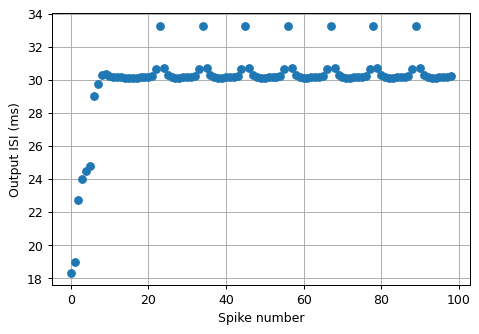

In [4]:
# Plotting output ISI
plot(np.diff(mon_neuron_output.t/ms),'o')
plt.ylabel('Output ISI (ms)')
plt.xlabel('Spike number')
plt.grid(True)

Congratulations! This is the end of Part 3, the last part of  Dynap-SE1 simulations :)